In [33]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from datetime import datetime, timedelta
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import intercluster_distance
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from wordcloud import WordCloud

import matplotlib
matplotlib.rcParams['font.family'] = 'Malgun Gothic'

### (1) 데이터 불러오기

In [27]:
clean_beauty_df = pd.read_csv('C:/Users/user/Desktop/databootcamp/tiktok_test/tiktok_post_clean_beauty_0124.csv')
glow_skin_df = pd.read_csv('C:/Users/user/Desktop/databootcamp/tiktok_test/tiktok_post_glow_skin_0123.csv')
kbeauty_skin_care_df = pd.read_csv('C:/Users/user/Desktop/databootcamp/tiktok_test/tiktok_post_kbeauty_skin_care_0124.csv')
korean_skincare_df = pd.read_csv('C:/Users/user/Desktop/databootcamp/tiktok_test/tiktok_post_korean_skincare_0124.csv')

### (2)전처리

#### 전처리_1 : 각 df별 중복행 제거

In [28]:
clean_beauty_df.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=True)
clean_beauty_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   like          200 non-null    object
 1   comment       200 non-null    object
 2   save          200 non-null    object
 3   titoker_name  200 non-null    object
 4   date          200 non-null    object
 5   info          200 non-null    object
dtypes: object(6)
memory usage: 9.5+ KB


In [29]:
glow_skin_df.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=True)
glow_skin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   like           187 non-null    object
 1   comment        187 non-null    int64 
 2   save           187 non-null    object
 3   tiktoker_name  187 non-null    object
 4   date           187 non-null    object
 5   info           187 non-null    object
dtypes: int64(1), object(5)
memory usage: 8.9+ KB


In [30]:
kbeauty_skin_care_df.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=True)
kbeauty_skin_care_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   like           199 non-null    object
 1   comment        199 non-null    object
 2   save           199 non-null    object
 3   tiktoker_name  199 non-null    object
 4   date           199 non-null    object
 5   info           199 non-null    object
dtypes: object(6)
memory usage: 9.5+ KB


In [31]:
korean_skincare_df.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=True)
korean_skincare_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   like           197 non-null    object
 1   comment        197 non-null    object
 2   save           197 non-null    object
 3   tiktoker_name  197 non-null    object
 4   date           197 non-null    object
 5   info           196 non-null    object
dtypes: object(6)
memory usage: 9.4+ KB


#### 전처리_2 : 각 df별 키워드 컬럼 만들어주기
> - 어떤 검색어를 입력하여 추출한 영상인지 알기 위해 검색어 컬럼을 만들어줌

In [32]:
# clean_beauty_df
for i in range(len(clean_beauty_df)):
    clean_beauty_df.loc[i, 'search_term'] = 'clean_beauty'

# glow_skin_df
for i in range(len(glow_skin_df)):
    glow_skin_df.loc[i, 'search_term'] = 'glow skin'

# kbeauty_skin_care_df
for i in range(len(kbeauty_skin_care_df)):
    kbeauty_skin_care_df.loc[i, 'search_term'] = 'kbeauty skin care'

# korean_skincare_df
for i in range(len(korean_skincare_df)):
    korean_skincare_df.loc[i, 'search_term'] = 'korean skincare'

#### 전처리_3 : 각 df별 노출 순서 컬럼 만들어주기 
> - 각 검색어를 입력했을 때 영상들이 몇 번째에 떴는지에 대한 컬럼 만들어주기

In [33]:
# clean_beauty_df
for i in range(len(clean_beauty_df)):
    clean_beauty_df.loc[i, 'vedio_order'] = i + 1

# glow_skin_df
for i in range(len(glow_skin_df)):
    glow_skin_df.loc[i, 'vedio_order'] = i + 1

# kbeauty_skin_care_df
for i in range(len(kbeauty_skin_care_df)):
    kbeauty_skin_care_df.loc[i, 'vedio_order'] = i + 1

# korean_skincare_df
for i in range(len(korean_skincare_df)):
    korean_skincare_df.loc[i, 'vedio_order'] = i + 1

clean_beauty_df['vedio_order'] = clean_beauty_df['vedio_order'].astype(int)
glow_skin_df['vedio_order'] = glow_skin_df['vedio_order'].astype(int)
kbeauty_skin_care_df['vedio_order'] = kbeauty_skin_care_df['vedio_order'].astype(int)
korean_skincare_df['vedio_order'] = korean_skincare_df['vedio_order'].astype(int)

#### 전처리_5 : clean_beauty_df 컬럼 이름 바꿔주기
> - 틱톡커 이름(tiktoker_name)컬럼이 titoker_name으로 잘못 입력되어 있어서 tiktoker_name으로 바꿔줌

In [34]:
clean_beauty_df.rename(columns={'titoker_name':'tiktoker_name'}, inplace=True)

#### 전처리_4 : df 합치기

In [8]:
cb_gl_concat = pd.concat([clean_beauty_df,glow_skin_df], axis=0, ignore_index=True)
kbs_ks_concat = pd.concat([kbeauty_skin_care_df,korean_skincare_df], axis=0, ignore_index=True)
final_df = pd.concat([cb_gl_concat,kbs_ks_concat], axis=0, ignore_index=True)
final_df

NameError: name 'clean_beauty_df' is not defined

#### 전처리_5 : 숫자형, 날짜형 컬럼
> - view, like, comment, save 컬럼 : 단위(k,m) 변환
> - date
    >> - 25년도 1월 업로드한 경우 2025-01-nn으로 변환 
    >> - nh ago, nd ago, 1w ago인 경우 2025-01-21기준으로 날짜 계산

##### 5-1. date 컬럼 형식 통일 및 datetime으로 변환

In [36]:
def preprocess_date(df):
    today = datetime(2025, 1, 21)

    for i in range(len(df)):
    
        if len(df['date'][i]) >= 8:
            df.loc[i, 'upload_date'] = df['date'][i]
    
        elif len(df['date'][i]) >= 6:
            date = df['date'][i].replace(' ','')
            alphabet_list = [a for a in date]
    
            if 'h' in alphabet_list:
                df.loc[i, 'upload_date'] = today
    
            elif 'd' in alphabet_list:
                day = alphabet_list[0]
                day = int(day)
                df.loc[i, 'upload_date'] = today - timedelta(days=day)
    
            elif 'w' in alphabet_list:
                week = alphabet_list[0]
                week = int(week)
                df.loc[i, 'upload_date'] = today - timedelta(weeks=week)
    
        elif len(df['date'][i]) == 4:
            df.loc[i, 'upload_date'] = '2025-' + df['date'][i]
    
        elif len(df['date'][i]) == 3:
            df.loc[i, 'upload_date'] = '2025-' + df['date'][i]

    # datetime형으로 변환
    df['upload_date'] = pd.to_datetime(df['upload_date'], format="%Y-%m-%d", errors='coerce')


preprocess_date(final_df)

In [37]:
# 결과 확인 1
final_df.tail()

like comment   save tiktoker_name        date  \
778   21.8K     187   6709     4chriisty    2024-6-9   
779  216.3K     381  22.6K  moonskinclub   2023-2-26   
780    9841      59   2616        koocat  2024-11-18   
781     881       8     73    ririsglow_   2024-8-26   
782  226.5K    1086  55.5K     amyflamy1        1-11   

                                                  info      search_term  \
778  use my yesstyle rewards code CRISPY5 to save m...  korean skincare   
779  ✨✨douyin evening skincare routine ✨✨ D: 248154...  korean skincare   
780  (non sponsored) a very candid random vid but i...  korean skincare   
781  I’m not leaving the house once my 12 step skin...  korean skincare   
782  Cheap skincare routine pt.2 #ILLIYOONpartner #...  korean skincare   

     vedio_order upload_date  
778          193  2024-06-09  
779          194  2023-02-26  
780          195  2024-11-18  
781          196  2024-08-26  
782          197  2025-01-11

In [38]:
# 결과 확인 2
print(final_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   like           783 non-null    object        
 1   comment        783 non-null    object        
 2   save           783 non-null    object        
 3   tiktoker_name  783 non-null    object        
 4   date           783 non-null    object        
 5   info           782 non-null    object        
 6   search_term    783 non-null    object        
 7   vedio_order    783 non-null    int64         
 8   upload_date    779 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 55.2+ KB
None


#### view, like, comment, save컬럼 단위 변환

In [39]:
# like 컬럼 단위 전처리

def process_like(df):
    for i in range(len(df)):
        like = df['like'][i].replace(' ','')
        like_list = [a for a in like]
        if 'K' in like_list:
            num = like.split('K')[0]
            num = float(num)
            like_cal = num*1000
            df.loc[i, 'like_cnt'] = like_cal
        elif 'M' in like_list:
            num = like.split('M')[0]
            num = float(num)
            like_cal = num*1000000
            df.loc[i, 'like_cnt'] = like_cal
        else:
            num = df['like'][i].replace(' ','')
            like_cal = float(num)
            df.loc[i, 'like_cnt'] = like_cal

process_like(final_df)

In [40]:
final_df['tiktoker_name'].nunique()

358

In [41]:
# comment 컬럼 단위 전처리

def process_comment(df):
    for i in range(len(df)):
        comment = str(df['comment'][i]).replace(' ','')
        comment_list = [a for a in comment]
        if 'K' in comment_list:
            num = comment.split('K')[0]
            num = float(num)
            comment_cal = num*1000
            df.loc[i, 'comment_cnt'] = comment_cal
        elif 'M' in comment_list:
            num = comment.split('M')[0]
            num = float(num)
            comment_cal = num*1000000
            df.loc[i, 'comment_cnt'] = comment_cal
        else:
            num = str(df['comment'][i]).replace(' ','')
            comment_cal = float(num)
            df.loc[i, 'comment_cnt'] = comment_cal

process_comment(final_df)

In [42]:
# save 컬럼 단위 전처리

def process_save(df):
    for i in range(len(df)):
        save = df['save'][i].replace(' ','')
        save_list = [a for a in save]
        if 'K' in save_list:
            num = save.split('K')[0]
            num = float(num)
            save_cal = num*1000
            df.loc[i, 'save_cnt'] = save_cal
        elif 'M' in save_list:
            num = save.split('M')[0]
            num = float(num)
            save_cal = num*1000000
            df.loc[i, 'save_cnt'] = save_cal
        else:
            num = df['save'][i].replace(' ','')
            save_cal = float(num)
            df.loc[i, 'save_cnt'] = save_cal

process_save(final_df)

In [43]:
# like_cnt, comment_cnt, save_cnt컬럼 float에서 int로 변환

final_df['like_cnt'] = final_df['like_cnt'].round(0).astype(int)
final_df['comment_cnt'] = final_df['comment_cnt'].round(0).astype(int)
final_df['save_cnt'] = final_df['save_cnt'].round(0).astype(int)

In [44]:
# 결과 확인 1
final_df.head(5)

like comment  save           tiktoker_name       date  \
0  1563      73   894             morganlkeen   2024-9-5   
1  1337     102   189       therealkatiestone        1-3   
2  8057     164  5654             kylies.muse   2024-2-1   
3   831      32   432          balancewithani   2024-7-2   
4  5634     104   542  labmuffinbeautyscience  2024-6-22   

                                                info   search_term  \
0  Replying to @user8022071884889 Non-Toxic Makeu...  clean_beauty   
1  #greenscreen new year new diagram #cleansers #...  clean_beauty   
2  Replying to @MTMama3 clean makeup options! Som...  clean_beauty   
3  I've been looking for a non-toxic beauty brand...  clean_beauty   
4  Clean beauty isn’t making products safer - tha...  clean_beauty   

   vedio_order upload_date  like_cnt  comment_cnt  save_cnt  
0            1  2024-09-05      1563           73       894  
1            2  2025-01-03      1337          102       189  
2            3  2024-02-01      8057          164      5654  
3            4  2024-07-02       831           32       432  
4            5  2024-06-22      5634          104       542

In [45]:
# 결과 확인 2
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   like           783 non-null    object        
 1   comment        783 non-null    object        
 2   save           783 non-null    object        
 3   tiktoker_name  783 non-null    object        
 4   date           783 non-null    object        
 5   info           782 non-null    object        
 6   search_term    783 non-null    object        
 7   vedio_order    783 non-null    int64         
 8   upload_date    779 non-null    datetime64[ns]
 9   like_cnt       783 non-null    int64         
 10  comment_cnt    783 non-null    int64         
 11  save_cnt       783 non-null    int64         
dtypes: datetime64[ns](1), int64(4), object(7)
memory usage: 73.5+ KB


### 전처리_2 : 해시태그 컬럼 생성
> - 크롤링 한 데이터를 csv파일로 변환하는 과정에서 hash_tag컬럼의 일부 행들이 손상되는 문제 발생
> - info 컬럼에서 해시태그 추출하여 해시태그 컬럼 다시 생성

#### info 컬럼에서 해시태그 추출

In [46]:
def new_hash_tag_process(df):
    for i in range(len(df)):
        info = str(df['info'][i])
        info_split_list = info.split(' ')
        hash_tag_list = []
        for a in info_split_list:
            if a.startswith('#'):
                hash_tag_list.append(a)
            elif a.startswith('@'):
                hash_tag_list.append(a)
            else:
                pass
        df.loc[i, 'hash_tag'] = ','.join(hash_tag_list)

new_hash_tag_process(final_df)

In [47]:
# 결과 확인
final_df.head(3)

like comment  save      tiktoker_name      date  \
0  1563      73   894        morganlkeen  2024-9-5   
1  1337     102   189  therealkatiestone       1-3   
2  8057     164  5654        kylies.muse  2024-2-1   

                                                info   search_term  \
0  Replying to @user8022071884889 Non-Toxic Makeu...  clean_beauty   
1  #greenscreen new year new diagram #cleansers #...  clean_beauty   
2  Replying to @MTMama3 clean makeup options! Som...  clean_beauty   

   vedio_order upload_date  like_cnt  comment_cnt  save_cnt  \
0            1  2024-09-05      1563           73       894   
1            2  2025-01-03      1337          102       189   
2            3  2024-02-01      8057          164      5654   

                                            hash_tag  
0                                 @user8022071884889  
1  #greenscreen,#cleansers,#skincare,#beauty,#bea...  
2                                           @MTMama3

In [48]:
# 결과 확인 2
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   like           783 non-null    object        
 1   comment        783 non-null    object        
 2   save           783 non-null    object        
 3   tiktoker_name  783 non-null    object        
 4   date           783 non-null    object        
 5   info           782 non-null    object        
 6   search_term    783 non-null    object        
 7   vedio_order    783 non-null    int64         
 8   upload_date    779 non-null    datetime64[ns]
 9   like_cnt       783 non-null    int64         
 10  comment_cnt    783 non-null    int64         
 11  save_cnt       783 non-null    int64         
 12  hash_tag       783 non-null    object        
dtypes: datetime64[ns](1), int64(4), object(8)
memory usage: 79.7+ KB


### 전처리_3 : 필요한 컬럼들로 데이터프레임 다시 생성

In [49]:
final_df.columns

Index(['like', 'comment', 'save', 'tiktoker_name', 'date', 'info',
       'search_term', 'vedio_order', 'upload_date', 'like_cnt', 'comment_cnt',
       'save_cnt', 'hash_tag'],
      dtype='object')

In [50]:
df = final_df[['search_term','vedio_order','tiktoker_name', 'upload_date', 'like_cnt', 'comment_cnt', 'save_cnt', 'info', 'hash_tag']]
df

search_term  vedio_order           tiktoker_name upload_date  \
0       clean_beauty            1             morganlkeen  2024-09-05   
1       clean_beauty            2       therealkatiestone  2025-01-03   
2       clean_beauty            3             kylies.muse  2024-02-01   
3       clean_beauty            4          balancewithani  2024-07-02   
4       clean_beauty            5  labmuffinbeautyscience  2024-06-22   
..               ...          ...                     ...         ...   
778  korean skincare          193               4chriisty  2024-06-09   
779  korean skincare          194            moonskinclub  2023-02-26   
780  korean skincare          195                  koocat  2024-11-18   
781  korean skincare          196              ririsglow_  2024-08-26   
782  korean skincare          197               amyflamy1  2025-01-11   

     like_cnt  comment_cnt  save_cnt  \
0        1563           73       894   
1        1337          102       189   
2        8057          164      5654   
3         831           32       432   
4        5634          104       542   
..        ...          ...       ...   
778     21800          187      6709   
779    216300          381     22600   
780      9841           59      2616   
781       881            8        73   
782    226500         1086     55500   

                                                  info  \
0    Replying to @user8022071884889 Non-Toxic Makeu...   
1    #greenscreen new year new diagram #cleansers #...   
2    Replying to @MTMama3 clean makeup options! Som...   
3    I've been looking for a non-toxic beauty brand...   
4    Clean beauty isn’t making products safer - tha...   
..                                                 ...   
778  use my yesstyle rewards code CRISPY5 to save m...   
779  ✨✨douyin evening skincare routine ✨✨ D: 248154...   
780  (non sponsored) a very candid random vid but i...   
781  I’m not leaving the house once my 12 step skin...   
782  Cheap skincare routine pt.2 #ILLIYOONpartner #...   

                                              hash_tag  
0                                   @user8022071884889  
1    #greenscreen,#cleansers,#skincare,#beauty,#bea...  
2                                             @MTMama3  
3                                                       
4                                     #skincarescience  
..                                                 ...  
778  #yslonglasting,#fyp,#kbeauty,#makeup,#korean,#...  
779  #fyp,#fypシ,#fypage,#fypシ゚viral,#skincareroutin...  
780  @SUKOSHI,#koreanskincare,#skincarefavorites,#k...  
781  #skincare,#kbeauty,#wonyoungism,#koreanskincar...  
782  #ILLIYOONpartner,#일리윤,#illiyoon,#kbeauty,#skin...  

[783 rows x 9 columns]

In [1]:
df.to_csv('tiktok_post_final_df.csv',index=False, encoding="utf-8-sig")

NameError: name 'df' is not defined

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from datetime import datetime, timedelta
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import intercluster_distance
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from wordcloud import WordCloud

import matplotlib
matplotlib.rcParams['font.family'] = 'Malgun Gothic'

### 전처리_4 : 자연어 처리

In [3]:
# 데이터 다시 불러오기 
df = pd.read_csv('/Users/jun/GitStudy/Data_4/src/project/project5/tiktok/0130/tiktok_post_final_df.csv')

In [4]:
df

search_term  vedio_order           tiktoker_name upload_date  \
0       clean_beauty            1             morganlkeen  2024-09-05   
1       clean_beauty            2       therealkatiestone  2025-01-03   
2       clean_beauty            3             kylies.muse  2024-02-01   
3       clean_beauty            4          balancewithani  2024-07-02   
4       clean_beauty            5  labmuffinbeautyscience  2024-06-22   
..               ...          ...                     ...         ...   
778  korean skincare          193               4chriisty  2024-06-09   
779  korean skincare          194            moonskinclub  2023-02-26   
780  korean skincare          195                  koocat  2024-11-18   
781  korean skincare          196              ririsglow_  2024-08-26   
782  korean skincare          197               amyflamy1  2025-01-11   

     like_cnt  comment_cnt  save_cnt  \
0        1563           73       894   
1        1337          102       189   
2        8057          164      5654   
3         831           32       432   
4        5634          104       542   
..        ...          ...       ...   
778     21800          187      6709   
779    216300          381     22600   
780      9841           59      2616   
781       881            8        73   
782    226500         1086     55500   

                                                  info  \
0    Replying to @user8022071884889 Non-Toxic Makeu...   
1    #greenscreen new year new diagram #cleansers #...   
2    Replying to @MTMama3 clean makeup options! Som...   
3    I've been looking for a non-toxic beauty brand...   
4    Clean beauty isn’t making products safer - tha...   
..                                                 ...   
778  use my yesstyle rewards code CRISPY5 to save m...   
779  ✨✨douyin evening skincare routine ✨✨ D: 248154...   
780  (non sponsored) a very candid random vid but i...   
781  I’m not leaving the house once my 12 step skin...   
782  Cheap skincare routine pt.2 #ILLIYOONpartner #...   

                                              hash_tag  
0                                   @user8022071884889  
1    #greenscreen,#cleansers,#skincare,#beauty,#bea...  
2                                             @MTMama3  
3                                                  NaN  
4                                     #skincarescience  
..                                                 ...  
778  #yslonglasting,#fyp,#kbeauty,#makeup,#korean,#...  
779  #fyp,#fypシ,#fypage,#fypシ゚viral,#skincareroutin...  
780  @SUKOSHI,#koreanskincare,#skincarefavorites,#k...  
781  #skincare,#kbeauty,#wonyoungism,#koreanskincar...  
782  #ILLIYOONpartner,#일리윤,#illiyoon,#kbeauty,#skin...  

[783 rows x 9 columns]

In [291]:
# nltk 에서 Punkt tokenizer & stopwords list를 다운로드
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /Users/jun/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/jun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [292]:
# porter stemmer 초기화 및 영어 불용어 세트 생성 (캐글 참고)
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# 특정 단어들을 불용어 목록에 추가
additional_stopwords = ['clean beauty', 'glow skin', 'kbeauty skin care', 'korean skincare', 'kbeauty', 'product', 'skincare', 'skin', 'beauty',
                        'Kbeauty', 'wonyoungism ', ' wonyoungism', 'wonyoungism', ' wonyoungism ', 'koreanskincare', 'Wonyoungism']
stop_words.update(additional_stopwords)

# 텍스트 전처리
def clean_text(text):
    if isinstance(text, str):
    
        # 소문자로 모두 변환
        text = text.lower()

        # URL 제거
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

        # 마크다운 스타일 링크 제거
        text = re.sub(r'\[.*?\]\(.*?\)', '', text)

        # @ 제거
        text = re.sub(r'@\w+', '', text)

        # 구두점, 특수문자 제거
        text = text.translate(str.maketrans('', '', string.punctuation))

        return text
    else:
        return text

# 텍스트 토큰화
def tokenize_text(text):
    if isinstance(text, str):
        return word_tokenize(text)
    else:
        return text

# 불용어 제거
def remove_stopwords(tokens):
    if isinstance(tokens, list):
        print(f"Tokens: {tokens}")  # 중간 결과 확인
        print(f"Stopwords: {stop_words}")
        return [token for token in tokens if token not in stop_words]
    else:
        return tokens

# -> stemming 함수 추가
def stem_tokens(tokens):
    if isinstance(tokens, list):
        return [stemmer.stem(token) for token in tokens]
    else:
        return tokens

# 저장
df['cleaned_info'] = df['info'].apply(clean_text)
df['cleaned_hash_tag'] = df['hash_tag'].apply(clean_text)

df['tokenized_info'] = df['cleaned_info'].apply(tokenize_text)
df['tokenized_hash_tag'] = df['cleaned_hash_tag'].apply(tokenize_text)

df['removed_info'] = df['tokenized_info'].apply(remove_stopwords)
df['removed_hash_tag'] = df['tokenized_hash_tag'].apply(remove_stopwords)

df['stpw_processed_info'] = df['removed_info'].apply(stem_tokens)
df['stpw_processed_hash_tag'] = df['removed_hash_tag'].apply(stem_tokens)

Tokens: ['replying', 'to', 'nontoxic', 'makeup', 'blushes', 'powder', 'cream', 'stick', 'cheek', 'stain', 'what', 'clean', 'swaps', 'do', 'you', 'want', 'to', 'see', 'next', 'brands', 'mentioned']
Stopwords: {'nor', 'below', 'can', 'no', 'up', 'yours', 's', 'don', 'there', 'd', 'during', 'be', "needn't", 'into', 'on', 'me', 'by', 'too', 'weren', 'Wonyoungism', 'its', 'or', 'theirs', 'shouldn', 'wasn', 'not', 'in', 'ours', 'do', 'shan', 'she', 'an', 'y', 'with', 'themselves', 'll', "wouldn't", 'what', 'so', 'when', 'such', 'until', 'of', 'does', "couldn't", "hasn't", "weren't", 'am', "you'll", 'doesn', 'before', 'aren', "haven't", 'because', 'any', 'some', 'more', 'only', 'again', 'having', 'yourselves', 'for', 'out', "you're", 'from', 'you', "mightn't", 'is', "isn't", 'wonyoungism ', 'we', 'if', 'have', 'the', "shouldn't", 'how', 'o', 'didn', 'skin', 'kbeauty skin care', 'herself', 'same', "it's", 'both', "aren't", 'haven', 'doing', 'needn', "won't", 'has', 'who', 'clean beauty', 'a', 

### 분석

#### 영상설명, 해시태그 워드클라우드

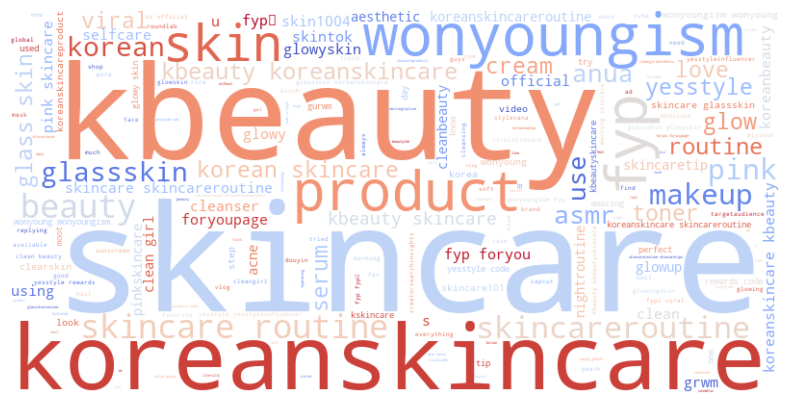

In [293]:
# 전처리된 틱톡 영상 설명 워드클라우드
wordcloud = WordCloud(width=800, height=400, 
                      background_color='white', colormap='coolwarm').generate(' '.join(df['cleaned_info'].dropna()))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
# plt.title("Word Cloud - Tiktok Vedio Information")
plt.show()

In [294]:
tag_final_list = []
for i in range(len(df)):
    tags = str(df['hash_tag'][i])
    tags_list = tags.split(',')
    tag_final_list.append(tags_list)
print(tag_final_list)

[['@user8022071884889'], ['#greenscreen', '#cleansers', '#skincare', '#beauty', '#beautybrand', '#wellness', '#healthyliving'], ['@MTMama3'], ['nan'], ['#skincarescience'], ['@lifebylane'], ['nan'], ['#cleanbeauty', '#wellness', '#lipstick', '#lipgloss', '#makeup'], ['##cleanbeauty', '#'], ['#fyp', '#makeuplook', '#cleangirlmakeup', '#cleanlook', '#naturalmakeup'], ['#hygiene', '#cleangirl', '#hygienetips'], ['#nontoxic', '#cleanbeauty', '#nontoxicbeauty', '#facewash'], ['@unnecessarily_paige', '#skincare', '#glassskin', '#glowyskin', '#skintips'], ['@EdwardZO'], ['#skincare', '#kbeauty', '#korean', '#skintok', '#kskincare', '#cleansing', '#cleansingoil', '#pores'], ['#oilcleansing', '#cleanser', '#doublecleansing', '#koreanskincare', '#pores'], ['#glassskin', '#clearskin', '#skincare', '#skincarejourney', '#healthyskin', '#viralskincare'], ['@RED', '#redchamber', '#cleanbeauty', '#blush', '#multipurposecream', '#บลัชออน'], ['#cleangirl', '#skincareroutine', '#skincaretips', '#SelfCare

In [295]:
tag_flat_list = sum(tag_final_list,[])
tag_df = pd.DataFrame({'tag':tag_flat_list})
tag_df

tag
0     @user8022071884889
1           #greenscreen
2             #cleansers
3              #skincare
4                #beauty
...                  ...
6563     #koreanskincare
6564              #gurwm
6565       #gurwmroutine
6566               #grwm
6567        #grwmroutine

[6568 rows x 1 columns]

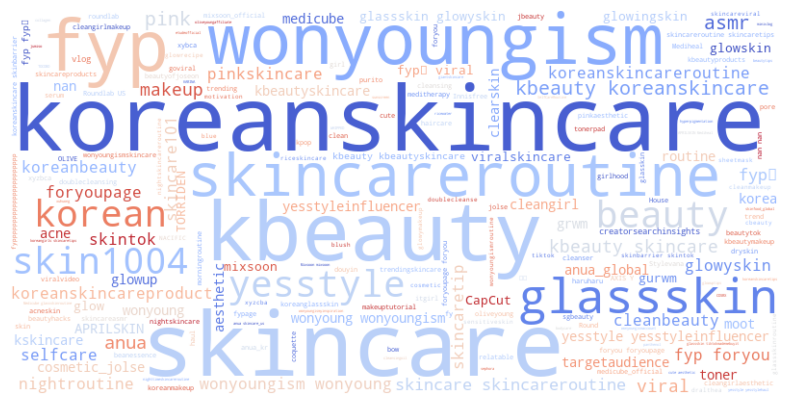

In [296]:
# 전처리된 틱톡 영상 해시태그 워드클라우드
wordcloud = WordCloud(width=800, height=400, 
                      background_color='white', colormap='coolwarm').generate(' '.join(tag_df['tag'].dropna()))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
# plt.title("Word Cloud - Tiktok Vedio Hash_tag")
plt.show()

In [297]:
df.columns

Index(['search_term', 'vedio_order', 'tiktoker_name', 'upload_date',
       'like_cnt', 'comment_cnt', 'save_cnt', 'info', 'hash_tag',
       'cleaned_info', 'cleaned_hash_tag', 'tokenized_info',
       'tokenized_hash_tag', 'removed_info', 'removed_hash_tag',
       'stpw_processed_info', 'stpw_processed_hash_tag'],
      dtype='object')

In [298]:
# Float 형식을 일반 숫자 형식으로 변경
pd.options.display.float_format = '{:.2f}'.format

# 틱톡커별 영상 개수 및 좋아요,댓글수,저장수 평균

tiktoker_groupby = df.groupby('tiktoker_name').agg({'upload_date':'count',
                                                    'like_cnt':'mean',
                                                    'comment_cnt':'mean',
                                                    'save_cnt':'mean'
                                                    }).sort_values('upload_date', ascending=False)

In [299]:
tiktoker_groupby.corr()

upload_date  like_cnt  comment_cnt  save_cnt
upload_date         1.00     -0.05        -0.01     -0.01
like_cnt           -0.05      1.00         0.75      0.72
comment_cnt        -0.01      0.75         1.00      0.45
save_cnt           -0.01      0.72         0.45      1.00

In [300]:
tiktoker_df = df['tiktoker_name'].value_counts().reset_index()
tiktoker_df[tiktoker_df['count'] >= 3]

tiktoker_name  count
0               mydelicate     37
1                velcroluv     33
2         caspertheghostyy     20
3               bwnniewony     17
4                 milkydew     15
5               aeiezo.pdf     15
6                   emchu_     14
7               songofskin     13
8                4chriisty     13
9               dearwonii_     11
10           .blissdiaries     11
11                  jeb_bi      9
12                olafflee      9
13            jasminnlily_      9
14                  koocat      9
15             _luvwonsnnx      9
16               onlydahia      7
17                 jaerini      7
18                 .m.egan      7
19               saeroniee      7
20       heartsfor.kbeauty      6
21            moonskinclub      6
22              ririsglow_      6
23              __.annie.s      5
24              danicolexx      5
25                tracyy_s      5
26          cleangirlhacks      5
27        cleanlivingkarly      5
28                 gae4hrv      5
29              aylennpark      5
30        thelipstickgirly      5
31               itsedonna      5
32          widyaatharva01      4
33          glowupwithinah      4
34         ameenbeautytips      4
35              its.kaylas      4
36               asiamelon      4
37              rosiehashs      4
38                 kwyeona      4
39                haruqhxz      4
40          luvsfor.jennie      4
41             vanessafaga      4
42          krystallee2222      4
43             izzydiaries      4
44         ooolongmilkteaa      4
45    thecleanskincarequiz      3
46              minseonk1m      3
47              misscasxie      3
48                 ofeemi7      3
49               fromh1ae_      3
50                .woniluv      3
51            lovelymiri05      3
52                monakoaa      3
53              nana.tan07      3
54  originalkoreanproducts      3
55               amyflamy1      3
56                ayheyt3u      3
57        soft.milky.latte      3

In [301]:
tiktoker_df['tiktoker_name'].unique

<bound method Series.unique of 0              mydelicate
1               velcroluv
2        caspertheghostyy
3              bwnniewony
4                milkydew
              ...        
353        makeup2themaxx
354              lifewjan
355     luongthuchien6868
356      alexwithwellness
357    mcloving.friedrice
Name: tiktoker_name, Length: 358, dtype: object>

In [302]:
# 24년도 10월월~25년도 1월말(현재)
recent_df = df[df['upload_date'] >= '2024-08-01']

In [303]:
recent_df

search_term  vedio_order      tiktoker_name upload_date  like_cnt  \
0       clean_beauty            1        morganlkeen  2024-09-05      1563   
1       clean_beauty            2  therealkatiestone  2025-01-03      1337   
10      clean_beauty           11       melodyyaslan  2024-10-11    166300   
14      clean_beauty           15       dongzik_skin  2024-12-05    754800   
15      clean_beauty           16   thelipstickgirly  2024-12-13   2400000   
..               ...          ...                ...         ...       ...   
776  korean skincare          191        _luvwonsnnx  2024-11-22      3761   
777  korean skincare          192         kellykekim  2024-12-16      5061   
780  korean skincare          195             koocat  2024-11-18      9841   
781  korean skincare          196         ririsglow_  2024-08-26       881   
782  korean skincare          197          amyflamy1  2025-01-11    226500   

     comment_cnt  save_cnt                                               info  \
0             73       894  Replying to @user8022071884889 Non-Toxic Makeu...   
1            102       189  #greenscreen new year new diagram #cleansers #...   
10          2378     87900  Arab women are the original clean girls… So he...   
14          2978    148000  all about cleansing #skincare #kbeauty #korean...   
15          5560    574300  Deep cleansing time ✨🧼 #oilcleansing #cleanser...   
..           ...       ...                                                ...   
776          133       754  Get glass skin instantly with these products! ...   
777           58      1378  My instant breakout soothing routine ASMR Prod...   
780           59      2616  (non sponsored) a very candid random vid but i...   
781            8        73  I’m not leaving the house once my 12 step skin...   
782         1086     55500  Cheap skincare routine pt.2 #ILLIYOONpartner #...   

                                              hash_tag  \
0                                   @user8022071884889   
1    #greenscreen,#cleansers,#skincare,#beauty,#bea...   
10                    #hygiene,#cleangirl,#hygienetips   
14   #skincare,#kbeauty,#korean,#skintok,#kskincare...   
15   #oilcleansing,#cleanser,#doublecleansing,#kore...   
..                                                 ...   
776  #kbeauty,#foryoupage,#foryou,#fyppp,#dontletth...   
777  @WHIPPED,#cleanser,#acneskin,#bumpyskin,#kbeau...   
780  @SUKOSHI,#koreanskincare,#skincarefavorites,#k...   
781  #skincare,#kbeauty,#wonyoungism,#koreanskincar...   
782  #ILLIYOONpartner,#일리윤,#illiyoon,#kbeauty,#skin...   

                                          cleaned_info  \
0    replying to  nontoxic makeup blushes powder cr...   
1    greenscreen new year new diagram cleansers ski...   
10   arab women are the original clean girls… so he...   
14   all about cleansing skincare kbeauty korean sk...   
15   deep cleansing time ✨🧼 oilcleansing cleanser d...   
..                                                 ...   
776  get glass skin instantly with these products  ...   
777  my instant breakout soothing routine asmr prod...   
780  non sponsored a very candid random vid but ive...   
781  i’m not leaving the house once my 12 step skin...   
782  cheap skincare routine pt2 illiyoonpartner 일리윤...   

                                      cleaned_hash_tag  \
0                                                        
1    greenscreencleansersskincarebeautybeautybrandw...   
10                         hygienecleangirlhygienetips   
14   skincarekbeautykoreanskintokkskincarecleansing...   
15   oilcleansingcleanserdoublecleansingkoreanskinc...   
..                                                 ...   
776  kbeautyforyoupageforyoufypppdontletthisflopyes...   
777  cleanseracneskinbumpyskinkbeautyskintokviralsk...   
780  koreanskincareskincarefavoriteskoreanskincarer...   
781  skincarekbeautywonyoungismkoreanskincareskinca...   
782  illiyoonpartner일리윤illiyoonkbeautyskincareskinc...   

        

In [304]:
def upload_y_m(df):
    df['upload_date_str'] = df['upload_date'].astype(str)
    for i in range(len(df)):
        date = df['upload_date_str'][i]
        y_m = date[:7]
        df.loc[i,'upload_y_m'] = y_m

upload_y_m(df)

In [305]:
date_groupby = df.groupby('upload_y_m')['search_term'].count().reset_index()
date_groupby

upload_y_m  search_term
0     2020-02            1
1     2020-03            2
2     2020-05            2
3     2020-11            1
4     2021-02            1
5     2021-03            1
6     2021-05            1
7     2021-06            1
8     2021-07            2
9     2021-08            2
10    2021-10            2
11    2021-11            1
12    2021-12            2
13    2022-02            2
14    2022-04            2
15    2022-06            2
16    2022-07            2
17    2022-08            3
18    2022-09            1
19    2022-10            1
20    2022-11            4
21    2022-12            4
22    2023-01            7
23    2023-02            8
24    2023-03           19
25    2023-04            9
26    2023-05            8
27    2023-06            4
28    2023-07            9
29    2023-08           14
30    2023-09           11
31    2023-10           13
32    2023-11           13
33    2023-12           11
34    2024-01           12
35    2024-02           21
36    2024-03           28
37    2024-04           36
38    2024-05           29
39    2024-06           55
40    2024-07           57
41    2024-08           46
42    2024-09           57
43    2024-10           63
44    2024-11           67
45    2024-12           57
46    2025-01           85
47        nan            4

In [306]:
import pltKorean_mac
pltKorean_mac.set_font_manager()

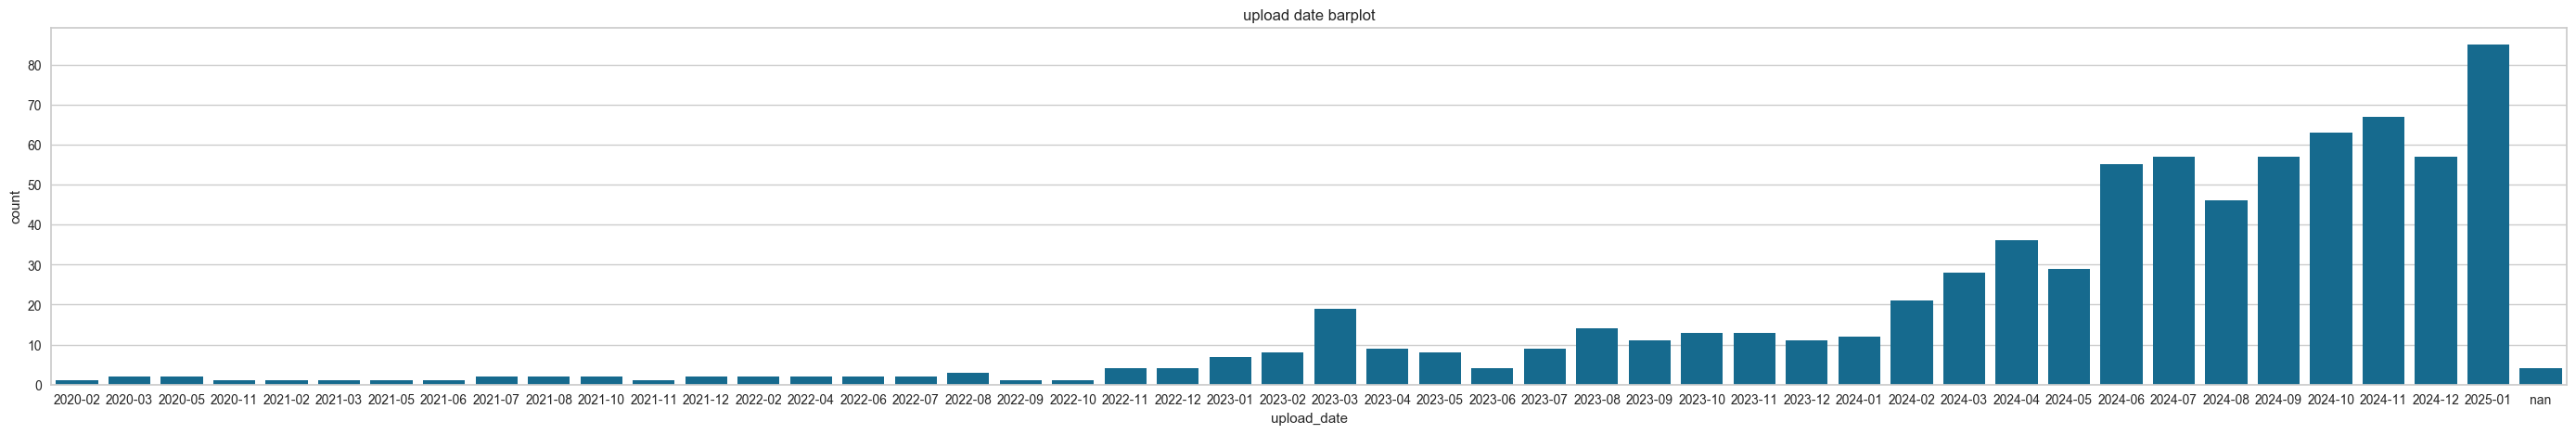

In [307]:
date_groupby = df.groupby('upload_y_m')['search_term'].count().reset_index()

fig, axes = plt.subplots(figsize=(35, 5), sharex=False)
sns.barplot(x='upload_y_m', y='search_term', data=date_groupby)
plt.title('upload date barplot')
plt.xlabel('upload_date')
plt.ylabel('count')
plt.show()

In [308]:
recent_df = df[df['upload_date']>='2024-06-01']

In [309]:
recent_df

search_term  vedio_order           tiktoker_name upload_date  \
0       clean_beauty            1             morganlkeen  2024-09-05   
1       clean_beauty            2       therealkatiestone  2025-01-03   
3       clean_beauty            4          balancewithani  2024-07-02   
4       clean_beauty            5  labmuffinbeautyscience  2024-06-22   
5       clean_beauty            6             morganlkeen  2024-07-10   
..               ...          ...                     ...         ...   
777  korean skincare          192              kellykekim  2024-12-16   
778  korean skincare          193               4chriisty  2024-06-09   
780  korean skincare          195                  koocat  2024-11-18   
781  korean skincare          196              ririsglow_  2024-08-26   
782  korean skincare          197               amyflamy1  2025-01-11   

     like_cnt  comment_cnt  save_cnt  \
0        1563           73       894   
1        1337          102       189   
3         831           32       432   
4        5634          104       542   
5        7288          165      4509   
..        ...          ...       ...   
777      5061           58      1378   
778     21800          187      6709   
780      9841           59      2616   
781       881            8        73   
782    226500         1086     55500   

                                                  info  \
0    Replying to @user8022071884889 Non-Toxic Makeu...   
1    #greenscreen new year new diagram #cleansers #...   
3    I've been looking for a non-toxic beauty brand...   
4    Clean beauty isn’t making products safer - tha...   
5    Replying to @lifebylane Clean & Non-Toxic Skin...   
..                                                 ...   
777  My instant breakout soothing routine ASMR Prod...   
778  use my yesstyle rewards code CRISPY5 to save m...   
780  (non sponsored) a very candid random vid but i...   
781  I’m not leaving the house once my 12 step skin...   
782  Cheap skincare routine pt.2 #ILLIYOONpartner #...   

                                              hash_tag  \
0                                   @user8022071884889   
1    #greenscreen,#cleansers,#skincare,#beauty,#bea...   
3                                                  NaN   
4                                     #skincarescience   
5                                          @lifebylane   
..                                                 ...   
777  @WHIPPED,#cleanser,#acneskin,#bumpyskin,#kbeau...   
778  #yslonglasting,#fyp,#kbeauty,#makeup,#korean,#...   
780  @SUKOSHI,#koreanskincare,#skincarefavorites,#k...   
781  #skincare,#kbeauty,#wonyoungism,#koreanskincar...   
782  #ILLIYOONpartner,#일리윤,#illiyoon,#kbeauty,#skin...   

                                          cleaned_info  \
0    replying to  nontoxic makeup blushes powder cr...   
1    greenscreen new year new diagram cleansers ski...   
3    ive been looking for a nontoxic beauty brand t...   
4    clean beauty isn’t making products safer  that...   
5    replying to  clean  nontoxic skincare face was...   
..                                                 ...   
777  my instant breakout soothing routine asmr prod...   
778  use my yesstyle rewards code crispy5 to save m...   
780  non sponsored a very candid random vid but ive...   
781  i’m not leaving the house once my 12 step skin...   
782  cheap skincare routine pt2 illiyoonpartner 일리윤...   

                                      cleaned_hash_tag  \
0                                                        
1    greenscreencleansersskincarebeautybeautybrandw...   
3                                                  NaN   
4                                      skincarescience   
5                                                        
..                                                 ...   
777  cleanseracneskinbumpyskinkbeautyskintokviralsk...   
778  yslonglastingfypkbeautymakeupkoreankoreayessty...   
780  koreanskincareskincarefavoritesko

In [310]:
import pandas as pd

txt = ""
for t in recent_df["hash_tag"]:
    txt += str(t) + ","

# 태그를 분리하여 DataFrame 생성
tag_df = pd.DataFrame(txt.split(","), columns=["tag"])  

tag_df = tag_df[(tag_df["tag"].str.strip() != "" ) & (tag_df["tag"].str.strip() != "nan")]

# 태그별 등장 횟수 계산
tag_counts = tag_df["tag"].value_counts()

print(tag_counts)


tag
#kbeauty            286
#koreanskincare     253
#skincare           247
#wonyoungism        194
#fyp                134
                   ... 
#peeloffmask          1
@miguhara_global      1
#xyzbcafypシ           1
#acnefighter          1
#gurwmroutine         1
Name: count, Length: 966, dtype: int64


In [311]:
tag_count =  tag_df["tag"].value_counts().reset_index()
tag_count

tag  count
0            #kbeauty    286
1     #koreanskincare    253
2           #skincare    247
3        #wonyoungism    194
4                #fyp    134
..                ...    ...
961      #peeloffmask      1
962  @miguhara_global      1
963       #xyzbcafypシ      1
964      #acnefighter      1
965     #gurwmroutine      1

[966 rows x 2 columns]

/opt/homebrew/Caskroom/miniconda/base/envs/leo4study/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10133 (\N{HEAVY PLUS SIGN}) missing from font(s) Arial Unicode MS.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/envs/leo4study/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129719 (\N{LOTUS}) missing from font(s) Arial Unicode MS.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/envs/leo4study/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127872 (\N{RIBBON}) missing from font(s) Arial Unicode MS.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/envs/leo4study/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 120257 (\N{MATHEMATICAL SANS-SERIF SMALL H}) missing from font(s) Arial Unicode MS.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda

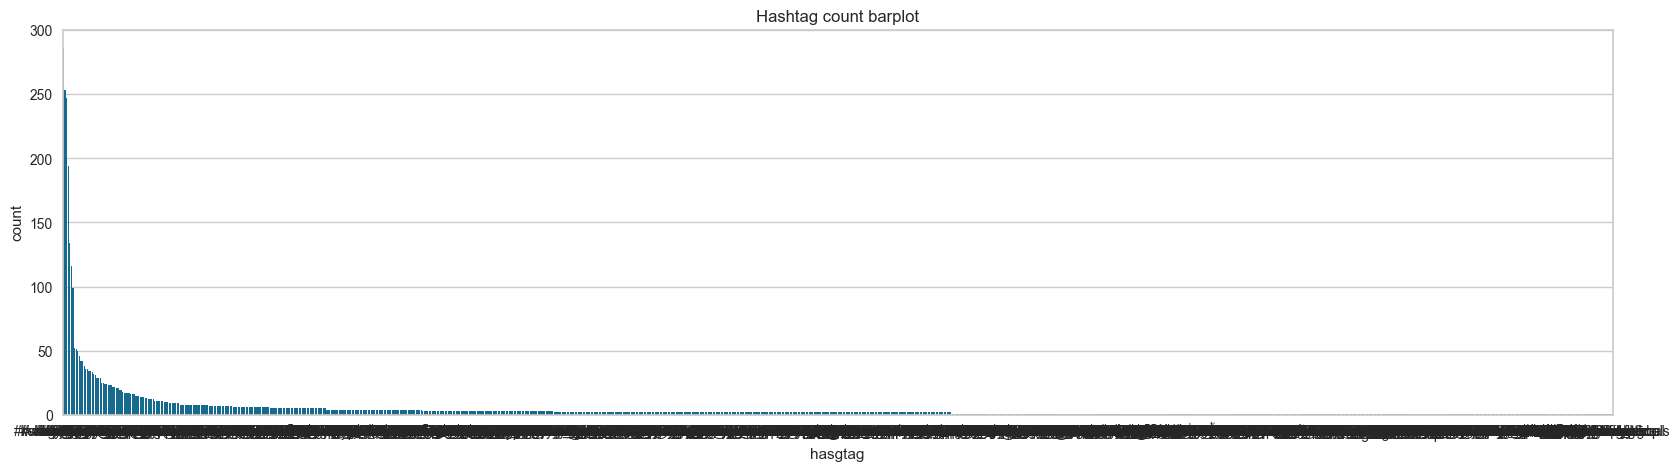

In [312]:
fig, axes = plt.subplots(figsize=(20, 5), sharex=False)
sns.barplot(x='tag', y='count', data=tag_count)
plt.title('Hashtag count barplot')
plt.xlabel('hasgtag')
plt.ylabel('count')
plt.show()

In [313]:
# 1162개개 중 25개 
tag_count[tag_count['count']>=20]
# skincare, koreanskincare, kbeauty
# skincareroutine, glassskin, 
# glowyskin, viral, skintok, cleanbeauty, skincaretips, asmr, glowup, anua, pink, clearskin

# 우리 회사랑 잘 어울리는 해시태그
# skintok, #ASMR
# 
# 사담 ( 제 생각 )
# 1. 파이 작은 곳 공략 작은 카테고리 내에서 1등 먹겠단 마인드 내 바운더리 생성 꽉 잡고 내가 여기 카테고리 짱이다 > 카테고리 자체가 우리 브랜드, 내 캐릭터 됨
# 2. 내 색깔에 딱 맞는 하고싶은 카테고리 하나. >> 화장품 브랜드 >> 자연 유래성분 화장품 >> #나는 사랑한다 > 사람 xx 
# 3. 요즘 뜨는 해시태그 >> chill guy 슬슬 죽기 시작하지만 >> 
# 4. 우리랑 관련되면서 파이 많은 언젠가 여기도 일등 먹고야 말겠다 > korean skin care ..
# 5. 인기 태그로 도배하면 무조건 뭍힘 ... 
# 6. 제일 무서운 점... 그걸 하기 어려움 >> 왜 ? 일단 인기 있다는 걸 어케 표현함? 트레픽이나 요즘 상승폭이나 이런거 우리는 못 하는데..abs
# 7. 그래서 우리는 뭐해야함? 말을 꺼내면 꺼낼 수록 슬퍼짐.....
# 8. 이렇게 얘기하다보면 뭐라도 생각날까 꺼냄.. 
# 9. 눈물을 훔친 채 그냥 넘어감..... 

tag  count
0                  #kbeauty    286
1           #koreanskincare    253
2                 #skincare    247
3              #wonyoungism    194
4                      #fyp    134
5          #skincareroutine    116
6                #glassskin     99
7                     #pink     52
8                   #korean     51
9                 #wonyoung     50
10                    #asmr     46
11                #yesstyle     42
12                  #foryou     42
13              #foryoupage     38
14                    #anua     36
15                 #skintok     36
16                  #beauty     34
17               #aesthetic     34
18                  #makeup     33
19                @YesStyle     32
20                @SKIN1004     31
21                #skin1004     29
22         #kbeautyskincare     29
23                   #viral     29
24            #pinkskincare     25
25            #skincaretips     25
26             #skincare101     24
27     #yesstyleinfluencers     24
28               #glowyskin     23
29  #koreanskincareproducts     23
30             @anua_global     23
31            #koreanbeauty     22
32                    #fypシ     22
33                    #grwm     21
34               @APRILSKIN     21

In [314]:
recent_df.reset_index()

index      search_term  vedio_order           tiktoker_name upload_date  \
0        0     clean_beauty            1             morganlkeen  2024-09-05   
1        1     clean_beauty            2       therealkatiestone  2025-01-03   
2        3     clean_beauty            4          balancewithani  2024-07-02   
3        4     clean_beauty            5  labmuffinbeautyscience  2024-06-22   
4        5     clean_beauty            6             morganlkeen  2024-07-10   
..     ...              ...          ...                     ...         ...   
482    777  korean skincare          192              kellykekim  2024-12-16   
483    778  korean skincare          193               4chriisty  2024-06-09   
484    780  korean skincare          195                  koocat  2024-11-18   
485    781  korean skincare          196              ririsglow_  2024-08-26   
486    782  korean skincare          197               amyflamy1  2025-01-11   

     like_cnt  comment_cnt  save_cnt  \
0        1563           73       894   
1        1337          102       189   
2         831           32       432   
3        5634          104       542   
4        7288          165      4509   
..        ...          ...       ...   
482      5061           58      1378   
483     21800          187      6709   
484      9841           59      2616   
485       881            8        73   
486    226500         1086     55500   

                                                  info  \
0    Replying to @user8022071884889 Non-Toxic Makeu...   
1    #greenscreen new year new diagram #cleansers #...   
2    I've been looking for a non-toxic beauty brand...   
3    Clean beauty isn’t making products safer - tha...   
4    Replying to @lifebylane Clean & Non-Toxic Skin...   
..                                                 ...   
482  My instant breakout soothing routine ASMR Prod...   
483  use my yesstyle rewards code CRISPY5 to save m...   
484  (non sponsored) a very candid random vid but i...   
485  I’m not leaving the house once my 12 step skin...   
486  Cheap skincare routine pt.2 #ILLIYOONpartner #...   

                                              hash_tag  \
0                                   @user8022071884889   
1    #greenscreen,#cleansers,#skincare,#beauty,#bea...   
2                                                  NaN   
3                                     #skincarescience   
4                                          @lifebylane   
..                                                 ...   
482  @WHIPPED,#cleanser,#acneskin,#bumpyskin,#kbeau...   
483  #yslonglasting,#fyp,#kbeauty,#makeup,#korean,#...   
484  @SUKOSHI,#koreanskincare,#skincarefavorites,#k...   
485  #skincare,#kbeauty,#wonyoungism,#koreanskincar...   
486  #ILLIYOONpartner,#일리윤,#illiyoon,#kbeauty,#skin...   

                                          cleaned_info  \
0    replying to  nontoxic makeup blushes powder cr...   
1    greenscreen new year new diagram cleansers ski...   
2    ive been looking for a nontoxic beauty brand t...   
3    clean beauty isn’t making products safer  that...   
4    replying to  clean  nontoxic skincare face was...   
..                                                 ...   
482  my instant breakout soothing routine asmr prod...   
483  use my yesstyle rewards code crispy5 to save m...   
484  non sponsored a very candid random vid but ive...   
485  i’m not leaving the house once my 12 step skin...   
486  cheap skincare routine pt2 illiyoonpartner 일리윤...   

                                      cleaned_hash_tag  \
0                                                        
1    greenscreencleansersskincarebeautybeautybrandw...   
2                                                  NaN   
3                                      skincarescience   
4                                                        
..                                                 ...   
482  cleanseracneskinbumpyskinkbeautyskintokviralsk...   
483  ysl

In [315]:
tag_count.head(3)

tag  count
0         #kbeauty    286
1  #koreanskincare    253
2        #skincare    247

In [316]:
recent_df.head(3)

search_term  vedio_order      tiktoker_name upload_date  like_cnt  \
0  clean_beauty            1        morganlkeen  2024-09-05      1563   
1  clean_beauty            2  therealkatiestone  2025-01-03      1337   
3  clean_beauty            4     balancewithani  2024-07-02       831   

   comment_cnt  save_cnt                                               info  \
0           73       894  Replying to @user8022071884889 Non-Toxic Makeu...   
1          102       189  #greenscreen new year new diagram #cleansers #...   
3           32       432  I've been looking for a non-toxic beauty brand...   

                                            hash_tag  \
0                                 @user8022071884889   
1  #greenscreen,#cleansers,#skincare,#beauty,#bea...   
3                                                NaN   

                                        cleaned_info  \
0  replying to  nontoxic makeup blushes powder cr...   
1  greenscreen new year new diagram cleansers ski...   
3  ive been looking for a nontoxic beauty brand t...   

                                    cleaned_hash_tag  \
0                                                      
1  greenscreencleansersskincarebeautybeautybrandw...   
3                                                NaN   

                                      tokenized_info  \
0  [replying, to, nontoxic, makeup, blushes, powd...   
1  [greenscreen, new, year, new, diagram, cleanse...   
3  [ive, been, looking, for, a, nontoxic, beauty,...   

                                  tokenized_hash_tag  \
0                                                 []   
1  [greenscreencleansersskincarebeautybeautybrand...   
3                                                NaN   

                                        removed_info  \
0  [replying, nontoxic, makeup, blushes, powder, ...   
1  [greenscreen, new, year, new, diagram, cleanse...   
3  [ive, looking, nontoxic, brand, actually, work...   

                                    removed_hash_tag  \
0                                                 []   
1  [greenscreencleansersskincarebeautybeautybrand...   
3                                                NaN   

                                 stpw_processed_info  \
0  [repli, nontox, makeup, blush, powder, cream, ...   
1  [greenscreen, new, year, new, diagram, cleanse...   
3  [ive, look, nontox, brand, actual, work, im, s...   

                             stpw_processed_hash_tag upload_date_str  \
0                                                 []      2024-09-05   
1  [greenscreencleansersskincarebeautybeautybrand...      2025-01-03   
3                                                NaN      2024-07-02   

  upload_y_m  
0    2024-09  
1    2025-01  
3    2024-07

In [317]:
# 태그 별 영상 수 및 총 좋아요 수 계산

recent_df['hash_tag'] = recent_df['hash_tag'].astype(str)

# 태그별 영상 수 및 총 좋아요 수 계산
tag_count['video_cnt'] = 0
tag_count['total_like'] = 0

recent_df['idx'] = recent_df.index

# ✅ 한 영상에서 한 태그가 한 번만 카운트되도록 처리
for i in range(len(tag_count)):
    tag = tag_count.loc[i, 'tag']
    
    # 해당 태그를 포함하는 영상 필터링
    matched_videos = recent_df[recent_df['hash_tag'].str.contains(tag, regex=False)].copy()
    
    # 🎯 각 video_id가 중복되지 않도록 unique한 영상 수만 계산
    tag_count.loc[i, 'video_cnt'] = matched_videos['idx'].nunique()
    
    # 🎯 같은 영상 내 여러 태그 중복 집계를 방지하여 총 좋아요 수 계산
    tag_count.loc[i, 'total_like'] = matched_videos.groupby('idx')['like_cnt'].first().sum()

# 결과 출력
print(tag_count)

/var/folders/29/5wmqbm4j3x10qv5vgm_bm8f80000gn/T/ipykernel_30930/907305875.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_df['hash_tag'] = recent_df['hash_tag'].astype(str)
/var/folders/29/5wmqbm4j3x10qv5vgm_bm8f80000gn/T/ipykernel_30930/907305875.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_df['idx'] = recent_df.index


                  tag  count  video_cnt  total_like
0            #kbeauty    286        286    15437135
1     #koreanskincare    253        258    22538551
2           #skincare    247        316    22013606
3        #wonyoungism    194        191     8441067
4                #fyp    134        150     6892134
..                ...    ...        ...         ...
961      #peeloffmask      1          1        4193
962  @miguhara_global      1          1        4193
963       #xyzbcafypシ      1          1      196400
964      #acnefighter      1          1      196400
965     #gurwmroutine      1          1      226500

[966 rows x 4 columns]


In [318]:
tag_count['like_mean'] = tag_count['total_like']/tag_count['video_cnt']

In [319]:
tag_count

tag  count  video_cnt  total_like  like_mean
0            #kbeauty    286        286    15437135   53976.00
1     #koreanskincare    253        258    22538551   87358.72
2           #skincare    247        316    22013606   69663.31
3        #wonyoungism    194        191     8441067   44194.07
4                #fyp    134        150     6892134   45947.56
..                ...    ...        ...         ...        ...
961      #peeloffmask      1          1        4193    4193.00
962  @miguhara_global      1          1        4193    4193.00
963       #xyzbcafypシ      1          1      196400  196400.00
964      #acnefighter      1          1      196400  196400.00
965     #gurwmroutine      1          1      226500  226500.00

[966 rows x 5 columns]

In [320]:
# 해시태그가 사용된 영상 개수가 30개 이상인 해시태그
tag_count[tag_count['video_cnt'] >= 30]

tag  count  video_cnt  total_like  like_mean
0            #kbeauty    286        286    15437135   53976.00
1     #koreanskincare    253        258    22538551   87358.72
2           #skincare    247        316    22013606   69663.31
3        #wonyoungism    194        191     8441067   44194.07
4                #fyp    134        150     6892134   45947.56
5    #skincareroutine    116        114     9362016   82122.95
6          #glassskin     99        106     5151499   48599.05
7               #pink     52         77     3386912   43985.87
8             #korean     51        305    24535245   80443.43
9           #wonyoung     50        191     8441067   44194.07
10              #asmr     46         47     4309483   91691.13
11          #yesstyle     42         50     1389986   27799.72
12            #foryou     42         72     3733577   51855.24
13        #foryoupage     38         39     1798686   46120.15
14              #anua     36         46     3888673   84536.37
15           #skintok     36         35     9610627  274589.34
16            #beauty     34         51     3821502   74931.41
17         #aesthetic     34         35      317591    9074.03
18            #makeup     33         38     5944603  156436.92
19          @YesStyle     32         33      788118   23882.36
20          @SKIN1004     31         31      614420   19820.00
23             #viral     29         50     3457383   69147.66
62             #korea     11        308    25659879   83311.30
82                #fy      8        153     6903705   45122.25
135             #glow      5         80     5106721   63834.01
163             #skin      5        333    23452325   70427.40
209             #wony      4        193     8561267   44358.90
368             @SKIN      2         33      630917   19118.70

In [321]:
tag_count.describe()

count  video_cnt  total_like  like_mean
count 966.00     966.00      966.00     966.00
mean    4.84       6.94   486838.28   81267.85
std    17.86      27.82  2006897.16  217844.38
min     1.00       1.00       14.00      14.00
25%     1.00       1.00     5185.00    2709.00
50%     2.00       2.00    35800.00   20202.83
75%     3.00       4.00   245700.00   70456.85
max   286.00     333.00 25659879.00 3500000.00

In [322]:
tag_count.sort_values('video_cnt',ascending=False).head(40)

tag  count  video_cnt  total_like  like_mean
163                 #skin      5        333    23452325   70427.40
2               #skincare    247        316    22013606   69663.31
62                 #korea     11        308    25659879   83311.30
8                 #korean     51        305    24535245   80443.43
0                #kbeauty    286        286    15437135   53976.00
1         #koreanskincare    253        258    22538551   87358.72
209                 #wony      4        193     8561267   44358.90
9               #wonyoung     50        191     8441067   44194.07
3            #wonyoungism    194        191     8441067   44194.07
82                    #fy      8        153     6903705   45122.25
4                    #fyp    134        150     6892134   45947.56
5        #skincareroutine    116        114     9362016   82122.95
6              #glassskin     99        106     5151499   48599.05
135                 #glow      5         80     5106721   63834.01
7                   #pink     52         77     3386912   43985.87
12                #foryou     42         72     3733577   51855.24
16                #beauty     34         51     3821502   74931.41
23                 #viral     29         50     3457383   69147.66
11              #yesstyle     42         50     1389986   27799.72
10                  #asmr     46         47     4309483   91691.13
14                  #anua     36         46     3888673   84536.37
13            #foryoupage     38         39     1798686   46120.15
18                #makeup     33         38     5944603  156436.92
17             #aesthetic     34         35      317591    9074.03
15               #skintok     36         35     9610627  274589.34
19              @YesStyle     32         33      788118   23882.36
368                 @SKIN      2         33      630917   19118.70
20              @SKIN1004     31         31      614420   19820.00
166          #skincaretip      4         29     2280139   78625.48
32                  #fypシ     22         29     1115143   38453.21
22       #kbeautyskincare     29         29      673359   23219.28
21              #skin1004     29         29      438030   15104.48
400   #yesstyleinfluencer      2         26      487255   18740.58
28             #glowyskin     23         26     1426113   54850.50
24          #pinkskincare     25         25      804640   32185.60
25          #skincaretips     25         25     1046093   41843.72
27   #yesstyleinfluencers     24         24      463455   19310.62
26           #skincare101     24         24      478525   19938.54
48                  #acne     14         24     2588165  107840.21
30           @anua_global     23         23      660585   28721.09

In [323]:
temp = tag_count[tag_count['video_cnt'] >= 20].reset_index(drop=True)

In [324]:
temp2 = temp.sort_values('like_mean', ascending=False).reset_index(drop=True).head(25)
temp2

tag  count  video_cnt  total_like  like_mean
0                  #skintok     36         35     9610627  274589.34
1                    #toner     19         22     5348110  243095.91
2                     #grwm     21         22     4260099  193640.86
3                   #makeup     33         38     5944603  156436.92
4                     #acne     14         24     2588165  107840.21
5                     #asmr     46         47     4309483   91691.13
6           #koreanskincare    253        258    22538551   87358.72
7                     #anua     36         46     3888673   84536.37
8                    #korea     11        308    25659879   83311.30
9          #skincareroutine    116        114     9362016   82122.95
10                  #korean     51        305    24535245   80443.43
11             #skincaretip      4         29     2280139   78625.48
12                   #trend      4         20     1564164   78208.20
13                  #beauty     34         51     3821502   74931.41
14  #koreanskincareproducts     23         23     1671800   72686.96
15   #koreanskincareproduct      4         23     1671800   72686.96
16                    #skin      5        333    23452325   70427.40
17                #skincare    247        316    22013606   69663.31
18                   #viral     29         50     3457383   69147.66
19                    #glow      5         80     5106721   63834.01
20               #glowyskin     23         26     1426113   54850.50
21                 #kbeauty    286        286    15437135   53976.00
22                  #foryou     42         72     3733577   51855.24
23                  #glowup     17         21     1055559   50264.71
24               #glassskin     99        106     5151499   48599.05

In [328]:
os.chdir('/Users/jun/GitStudy/Data_4/src/project/project5/tiktok/0130')

tag	video_cnt	total_like	like_mean
0	#skintok	35	9610627	274589.34
1	#toner	22	5348110	243095.91
2	#grwm	22	4260099	193640.86
3	#makeup	38	5944603	156436.92
4	#acne	24	2588165	107840.21
5	#asmr	47	4309483	91691.13
6	#koreanskincare	258	22538551	87358.72
7	#anua	46	3888673	84536.37
8	#korea	308	25659879	83311.30
9	#skincareroutine	114	9362016	82122.95
10	#korean	305	24535245	80443.43
11	#skincaretip	29	2280139	78625.48
12	#trend	20	1564164	78208.20
13	#beauty	51	3821502	74931.41
14	#koreanskincareproducts	23	1671800	72686.96
15	#koreanskincareproduct	23	1671800	72686.96
16	#skin	333	23452325	70427.40
17	#skincare	316	22013606	69663.31
18	#viral	50	3457383	69147.66
19	#glow	80	5106721	63834.01
20	#glowyskin	26	1426113	54850.50
21	#kbeauty	286	15437135	53976.00
22	#foryou	72	3733577	51855.24
23	#glowup	21	1055559	50264.71
24	#glassskin	106	5151499	48599.05

In [326]:
temp = temp.sort_values('like_mean', ascending=False).reset_index(drop=True).head(20)
temp = temp.sort_values('tag', ascending=True).reset_index(drop=True)

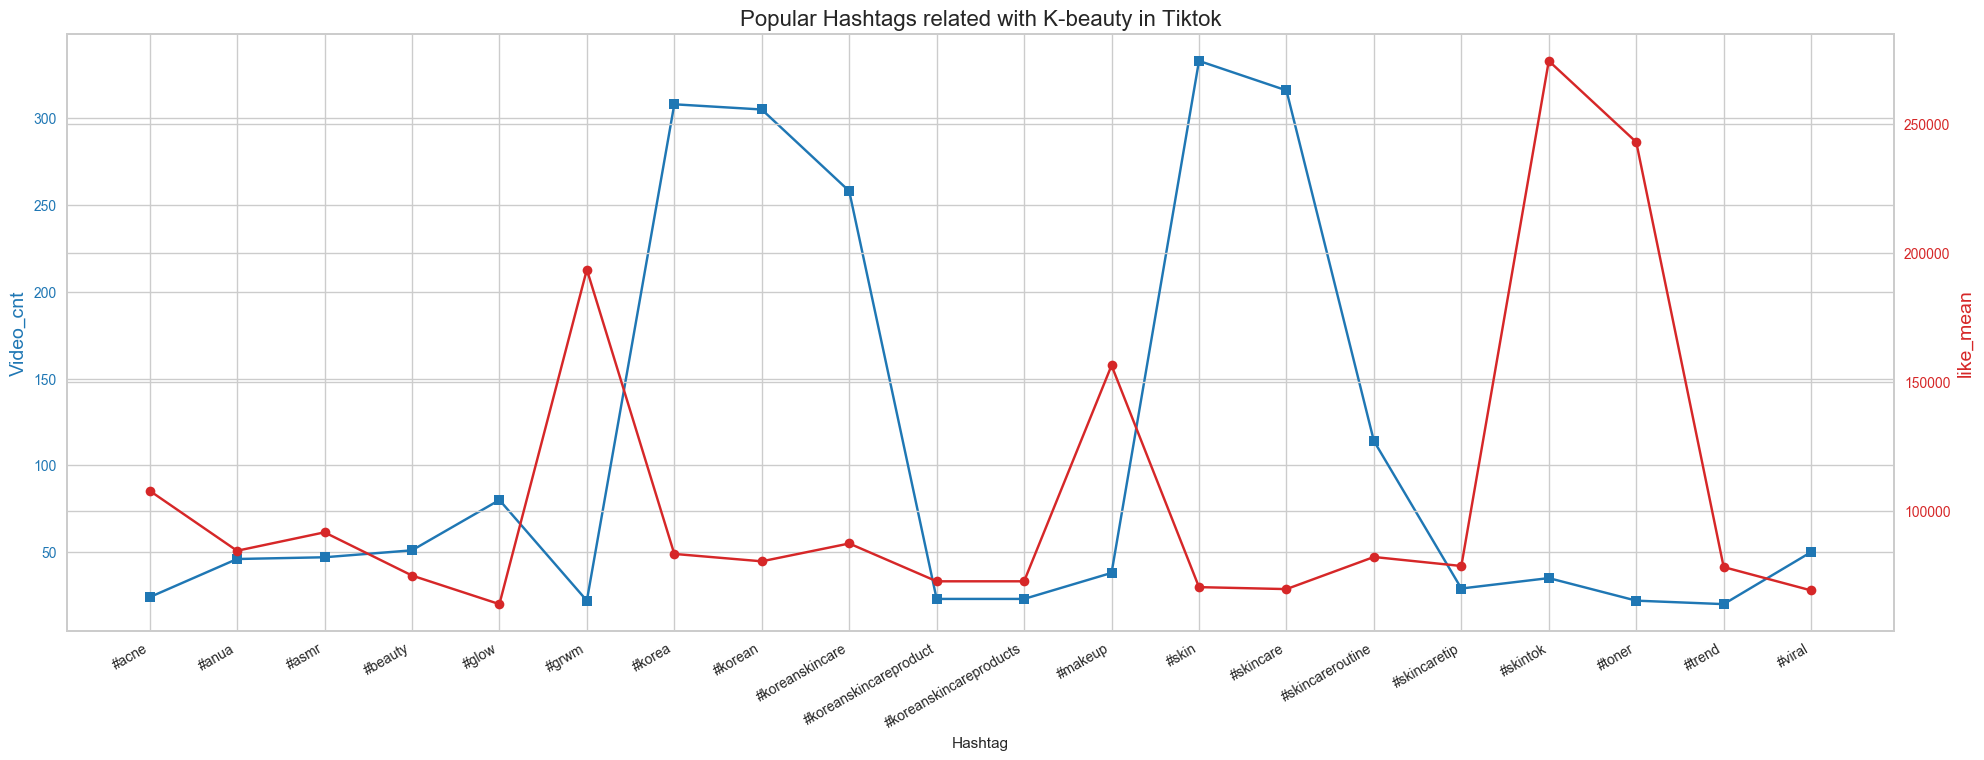

In [251]:
# left side : vedio_cnt
fig, ax1 = plt.subplots(figsize=(20, 8), sharex=False)
color_1 = 'tab:blue'
ax1.set_title('Popular Hashtags related with K-beauty in Tiktok', fontsize=16)
ax1.set_xlabel('Hashtag')
ax1.set_ylabel('Video_cnt', fontsize=14, color=color_1)
ax1.plot(temp.tag, temp.video_cnt, marker='s', color=color_1)
ax1.tick_params(axis='y', labelcolor=color_1)
# right side : like_mean
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color_2 = 'tab:red'
ax2.set_ylabel('like_mean', fontsize=14, color=color_2)
ax2.plot(temp.tag, temp.like_mean, marker='o', color=color_2)
ax2.tick_params(axis='y', labelcolor=color_2)
# Rotate x-axis labels by 45 degrees
fig.tight_layout()
plt.xticks(rotation=45)
# To make sure the x-axis labels don't overlap and fit properly
fig.autofmt_xdate()
plt.show()

In [252]:
recent_df['like_cnt'].mean()

92469.88911704312

In [253]:
tiktoker_df = pd.read_csv('/Users/jun/GitStudy/Data_4/src/project/project5/tiktok/0130/tiktoker_crawling_df_0127.csv')

In [254]:
tiktoker_df[tiktoker_df['name']=='.blissdiaries']

Unnamed: 0           name follower   view  like  comment save  \
270         270  .blissdiaries    81.7K   1785   259       24   27   
271         271  .blissdiaries    81.7K   1850   380       28   41   
272         272  .blissdiaries    81.7K   3090   525       33   60   
273         273  .blissdiaries    81.7K   9470  1908       60  282   
274         274  .blissdiaries    81.7K   6992  1400       74  169   
275         275  .blissdiaries    81.7K   5105   868       61   98   
276         276  .blissdiaries    81.7K   6356  1165       83  114   
277         277  .blissdiaries    81.7K   5555  1025       36  107   
278         278  .blissdiaries    81.7K  11.5K  2752      101  413   
279         279  .blissdiaries    81.7K   9156  1702       80  239   
280         280  .blissdiaries    81.7K   2710   472       34   47   
281         281  .blissdiaries    81.7K   3512   376       25   39   
282         282  .blissdiaries    81.7K   4593   701       32   79   
283         283  .blissdiaries    81.7K   7713  1649       76  213   
284         284  .blissdiaries    81.7K   9127  1379       57  177   
285         285  .blissdiaries    81.7K   7065  1071       52  143   
286         286  .blissdiaries    81.7K   7173   992       44   93   
287         287  .blissdiaries    81.7K   7116   982       55  127   
288         288  .blissdiaries    81.7K  14.4K  2065       71  260   
289         289  .blissdiaries    81.7K  12.8K  1564       83  179   
290         290  .blissdiaries    81.7K  19.3K  1713       73  282   
291         291  .blissdiaries    81.7K  13.8K  1435       75  166   
292         292  .blissdiaries    81.7K  30.3K  5389      138  877   
293         293  .blissdiaries    81.7K  14.5K  1831       50  267   
294         294  .blissdiaries    81.7K  10.3K   975       69  106   
295         295  .blissdiaries    81.7K  16.3K  2106       62  298   
296         296  .blissdiaries    81.7K  16.6K  2550       71  321   
297         297  .blissdiaries    81.7K  15.7K  2456       73  454   
298         298  .blissdiaries    81.7K   8462   923       46  116   
299         299  .blissdiaries    81.7K   9209   807       48   92   

           date                                           info_tag  \
270      2d ago  jumiso’s hydrating glow duo 🌊🌟 a must have !! ...   
271      3d ago  use code INF105KEIRAS for $$ off stylevana 🐰🎀 ...   
272        1-14  dear,klairs most loved trio set 🐰thank you @kl...   
273        1-11  the prettiest sweet scent 🐰🩰 mod blush- ariana...   
274         1-1  stylevana december makeup haul 🐰🎀 use code INF...   
275  2024-12-28  yesstyle opanchu usagi haul 🐰🎀 the cutest char...   
276  2024-12-27  yesstyle makeup haul 🐰🎀 products actually vira...   
277  2024-12-25  available on amazon-roundlab camellia deep col...   
278  2024-12-22  so prettyyy @Flower Knows Makeup the best chri...   
279  2024-12-22  @Flower Knows Makeup holiday chritmas box 🎄☃️ ...   
280  2024-12-21  @Lewkin holiday christmas pr box ☃️🎄❄️ soo man...   
281  2024-12-16  cutest blind box plush pendants from @luckyemm...   
282  2024-12-16  yesstyle free 100$ coupon haul ⋆౨ৎ˚⟡˖ ࣪ the pe...   
283  2024-11-30  november stylevana haull !! use stylevana code...   
284  2024-11-24  cute coquette necklace by @FanciMe jewelry 🐰🎀 ...   
285  2024-11-16  I received this product for free from Picky an...   
286  2024-11-11  clio x bazzaal pr haul ⋆౨ৎ˚⟡˖ ࣪ kbeauty black ...   
287   2024-11-9  Lewkins 10 step kbeauty glass skin box ⋆౨ৎ˚⟡˖ ...   
288   2024-11-6  stylevana october pr haul 🐰🎀 @Stylevana || pos...   
289  2024-10-21  The coolest korean lip and cheek sleek? The in...   
290  2024-10-14  A must have beauty advent calendar to end 2024...   
291   2024-10-4  ive found my new favourite toner pads 😋\n|I us...   
292   2024-10-2  decorate my clio palette with me 🐰🎀 clio palet...   
293   2024-10-2  peach & lily’s glass skin refining serum ⋆౨ৎ˚⟡...   
294   2024-9-30  Purito seoul August supporters campaign 🎋 - Pu...   
295   2024-9-2

In [255]:
def process_like(df):
    for i in range(len(df)):
        like = df['like'][i].replace(' ','')
        like_list = [a for a in like]
        if 'K' in like_list:
            num = like.split('K')[0]
            num = float(num)
            like_cal = num*1000
            df.loc[i, 'like_cnt'] = like_cal
        elif 'M' in like_list:
            num = like.split('M')[0]
            num = float(num)
            like_cal = num*1000000
            df.loc[i, 'like_cnt'] = like_cal
        else:
            num = df['like'][i].replace(' ','')
            like_cal = float(num)
            df.loc[i, 'like_cnt'] = like_cal

process_like(tiktoker_df)

In [256]:
tiktoker_df['like_cnt'].describe()

count      1680.00
mean      20198.40
std       88556.58
min           2.00
25%         526.50
50%        2127.50
75%        9179.00
max     1800000.00
Name: like_cnt, dtype: float64

In [257]:
# 사분위수 계산
Q1 = tiktoker_df['like_cnt'].quantile(0.25)  # 1사분위수
Q2 = tiktoker_df['like_cnt'].median()
Q3 = tiktoker_df['like_cnt'].quantile(0.75)  # 3사분위수
IQR = Q3 - Q1  # IQR (Interquartile Range)

# 사분위수 범위 내의 행만 필터링
#filtered_df = df[(df['컬럼명'] >= Q1) & (df['컬럼명'] <= Q3)]
tiktoker_df['like_cnt_scaled'] = (tiktoker_df['like_cnt'] - Q2) / (IQR*1.5)

# 이상치 기준 설정 (k 값 조절 가능)
k = 1.5
lower_bound = Q1 - (IQR * k)
upper_bound = Q3 + (IQR * k)
# 이상치가 아닌 값만 필터링
df_cleaned = tiktoker_df[(tiktoker_df['like_cnt'] >= lower_bound) & (tiktoker_df['like_cnt'] <= upper_bound)]

In [258]:
df_cleaned['like_cnt'].describe()

count    1440.00
mean     3491.19
std      4583.25
min         2.00
25%       397.75
50%      1521.50
75%      4550.75
max     22100.00
Name: like_cnt, dtype: float64

In [259]:
# follower 컬럼 단위 전처리

def process_follower(df):
    for i in range(len(df)):
        follower = df['follower'][i].replace(' ','')
        follower_list = [a for a in follower]
        if 'K' in follower_list:
            num = follower.split('K')[0]
            num = float(num)
            follower_cal = num*1000
            df.loc[i, 'follower_cnt'] = follower_cal
        elif 'M' in follower_list:
            num = follower.split('M')[0]
            num = float(num)
            follower_cal = num*1000000
            df.loc[i, 'follower_cnt'] = follower_cal
        else:
            num = df['follower'][i].replace(' ','')
            follower_cal = float(num)
            df.loc[i, 'follower_cnt'] = follower_cal

process_follower(tiktoker_df)

In [260]:
# 최소 광고비용 컬러러
def min_ad_cost_range(df):
    for i in range(len(df)):
        if df['follower_cnt'][i] >= 1000000:
            df.loc[i, 'tiktoker_size'] = 'mega_influancer'
            df.loc[i, 'ad_cost'] = 2500  # 숫자로 설정
        elif df['follower_cnt'][i] >= 500000:
            df.loc[i, 'tiktoker_size'] = 'mekro_influancer'
            df.loc[i, 'ad_cost'] = 1200
        elif df['follower_cnt'][i] >= 100000:
            df.loc[i, 'tiktoker_size'] = 'middle_influancer'
            df.loc[i, 'ad_cost'] = 125
        elif df['follower_cnt'][i] >= 10000:
            df.loc[i, 'tiktoker_size'] = 'micro_influancer'
            df.loc[i, 'ad_cost'] = 25
        elif df['follower_cnt'][i] >= 1000:
            df.loc[i, 'tiktoker_size'] = 'nano_influancer'
            df.loc[i, 'ad_cost'] = 5
        else:
            df.loc[i, 'tiktoker_size'] = 'under_influancer'
            df.loc[i, 'ad_cost'] = 0 
min_ad_cost_range(tiktoker_df)

In [261]:
tiktoker_df[tiktoker_df['tiktoker_size']=='micro_influancer']['name'].nunique()

20

In [206]:
### 뭐를 할까
- ppt 완성
- 인플루언서 영상 업로드 빈도 구하기


SyntaxError: invalid syntax (2827977428.py, line 2)

In [207]:
import pandas as pd
import numpy as np
import re
from datetime import datetime, timedelta

# ✅ 현재 날짜 기준
TODAY = datetime(2025, 1, 27)  # 현재 날짜 설정

# ✅ 'date' 열을 변환하는 함수 (에러 방지 추가)
def parse_date(date_str):
    date_str = str(date_str).strip().lower()  # 공백 제거, 소문자 변환

    # 1️⃣ MM-DD 형식 변환 (예: "1-14" → 2025-01-14)
    match_mmdd = re.fullmatch(r"(\d{1,2})-(\d{1,2})", date_str)
    if match_mmdd:
        month, day = map(int, match_mmdd.groups())  # 월, 일 추출
        return datetime(2025, month, day)  # 2025년으로 변환

    # 2️⃣ 숫자 + 단위(h, d, w) 변환 (예: "14h", "3d", "2w")
    match_relative = re.fullmatch(r"(\d+)([hdw])(?:\s*ago)?", date_str)  # " ago" 처리 추가
    if match_relative:
        num, unit = int(match_relative.group(1)), match_relative.group(2)  # 숫자, 단위 분리
        
        if unit == "h":  # 시간 단위
            return TODAY - timedelta(hours=num)
        elif unit == "d":  # 일 단위
            return TODAY - timedelta(days=num)
        elif unit == "w":  # 주 단위 (1주 = 7일)
            return TODAY - timedelta(weeks=num)

    # 3️⃣ 날짜 형식(YYYY-MM-DD) 변환
    try:
        return pd.to_datetime(date_str)  # YYYY-MM-DD 형식 변환
    except Exception as e:
        print(f"Failed to parse date: {date_str}. Error: {e}")
        return np.nan  # 변환 실패 시 NaT 반환

# ✅ 'date' 열 변환
tiktoker_df["date"] = tiktoker_df["date"].apply(parse_date)

# ✅ name 별로 업로드 간격 계산
tiktoker_df = tiktoker_df.sort_values(by=["name", "date"])  # 이름 + 날짜순 정렬
tiktoker_df["prev_date"] = tiktoker_df.groupby("name")["date"].shift(1)  # 이전 영상 날짜
tiktoker_df["upload_gap"] = (tiktoker_df["date"] - tiktoker_df["prev_date"]).dt.days  # 간격(일)

# ✅ 평균 업로드 주기 계산
upload_cycle = tiktoker_df.groupby("name")["upload_gap"].mean().reset_index()
upload_cycle.rename(columns={"upload_gap": "avg_upload_interval"}, inplace=True)

# ✅ 결과 출력
print(upload_cycle)

                 name  avg_upload_interval
0       .blissdiaries                 4.28
1             .m.egan                 5.03
2            .woniluv                 2.38
3           4chriisty                 2.69
4          __.annie.s                 3.14
5         _luvwonsnnx                 1.48
6          aeiezo.pdf                 3.69
7     ameenbeautytips                 0.14
8           amyflamy1                 1.62
9           asiamelon                 3.34
10           ayheyt3u                 5.76
11         aylennpark                 1.83
12         bwnniewony                 2.14
13   caspertheghostyy                 1.03
14     cleangirlhacks                 3.03
15   cleanlivingkarly                 0.76
16         danicolexx                 0.48
17         dearwonii_                 2.86
18             emchu_                 3.41
19          fromh1ae_                 2.38
20            gae4hrv                 3.76
21     glowupwithinah                 0.45
22         

In [208]:
tiktoker_df["date"]

299    2024-09-23
298    2024-09-27
295    2024-09-28
296    2024-09-28
297    2024-09-28
          ...    
1234   2024-06-09
1232   2024-06-10
1233   2024-06-10
1231   2024-06-12
1230   2024-08-31
Name: date, Length: 1680, dtype: datetime64[ns]

In [209]:
tiktoker_df[tiktoker_df['name']=='.blissdiaries']

Unnamed: 0           name follower   view  like  comment save       date  \
299         299  .blissdiaries    81.7K   9209   807       48   92 2024-09-23   
298         298  .blissdiaries    81.7K   8462   923       46  116 2024-09-27   
295         295  .blissdiaries    81.7K  16.3K  2106       62  298 2024-09-28   
296         296  .blissdiaries    81.7K  16.6K  2550       71  321 2024-09-28   
297         297  .blissdiaries    81.7K  15.7K  2456       73  454 2024-09-28   
294         294  .blissdiaries    81.7K  10.3K   975       69  106 2024-09-30   
292         292  .blissdiaries    81.7K  30.3K  5389      138  877 2024-10-02   
293         293  .blissdiaries    81.7K  14.5K  1831       50  267 2024-10-02   
291         291  .blissdiaries    81.7K  13.8K  1435       75  166 2024-10-04   
290         290  .blissdiaries    81.7K  19.3K  1713       73  282 2024-10-14   
289         289  .blissdiaries    81.7K  12.8K  1564       83  179 2024-10-21   
288         288  .blissdiaries    81.7K  14.4K  2065       71  260 2024-11-06   
287         287  .blissdiaries    81.7K   7116   982       55  127 2024-11-09   
286         286  .blissdiaries    81.7K   7173   992       44   93 2024-11-11   
285         285  .blissdiaries    81.7K   7065  1071       52  143 2024-11-16   
284         284  .blissdiaries    81.7K   9127  1379       57  177 2024-11-24   
283         283  .blissdiaries    81.7K   7713  1649       76  213 2024-11-30   
281         281  .blissdiaries    81.7K   3512   376       25   39 2024-12-16   
282         282  .blissdiaries    81.7K   4593   701       32   79 2024-12-16   
280         280  .blissdiaries    81.7K   2710   472       34   47 2024-12-21   
278         278  .blissdiaries    81.7K  11.5K  2752      101  413 2024-12-22   
279         279  .blissdiaries    81.7K   9156  1702       80  239 2024-12-22   
277         277  .blissdiaries    81.7K   5555  1025       36  107 2024-12-25   
276         276  .blissdiaries    81.7K   6356  1165       83  114 2024-12-27   
275         275  .blissdiaries    81.7K   5105   868       61   98 2024-12-28   
274         274  .blissdiaries    81.7K   6992  1400       74  169 2025-01-01   
273         273  .blissdiaries    81.7K   9470  1908       60  282 2025-01-11   
272         272  .blissdiaries    81.7K   3090   525       33   60 2025-01-14   
271         271  .blissdiaries    81.7K   1850   380       28   41 2025-01-24   
270         270  .blissdiaries    81.7K   1785   259       24   27 2025-01-25   

                                              info_tag  \
299  I recieved this product for free from picky an...   
298  I recieved this product for free from picky an...   
295  yesstyle perfect lips mix & match- swatches 🎀🩰...   
296  i cant help it okay 💔💔 use yesstyle rewards co...   
297  yesstyle perfect lips - mix & match 🐰🎀 the cut...   
294  Purito seoul August supporters campaign 🎋 - Pu...   
292  decorate my clio palette with me 🐰🎀 clio palet...   
293  peach & lily’s glass skin refining serum ⋆౨ৎ˚⟡...   
291  ive found my new favourite toner pads 😋\n|I us...   
290  A must have beauty advent calendar to end 2024...   
289  The coolest korean lip and cheek sleek? The in...   
288  stylevana october pr haul 🐰🎀 @Stylevana || pos...   
287  Lewkins 10 step kbeauty glass skin box ⋆౨ৎ˚⟡˖ ...   
286  clio x bazzaal pr haul ⋆౨ৎ˚⟡˖ ࣪ kbeauty black ...   
285  I received this product for free from Picky an...   
284  cute coquette necklace by @FanciMe jewelry 🐰🎀 ...   
283  november stylevana haull !! use stylevana code...   
281  cutest blind box plush pendants from @luckyemm...   
282  yesstyle free 100$ coupon haul ⋆౨ৎ˚⟡˖ ࣪ the pe...   
280  @Lewkin holiday christmas pr box ☃️🎄❄️ soo man...   
278  so prettyyy @Flower Knows Makeup the best chri...   
279  @Flower Knows Makeup holiday chritmas box 🎄☃️ ...   
277  available on amazon-roundlab camellia deep col...   
276  yesstyle makeup haul 🐰🎀 products actually vira...   
275  yesstyle opanchu usagi haul 🐰🎀 the cut

In [210]:
# ✅ 1차 차분(변화량) 계산
tiktoker_df["upload_gap_diff"] = tiktoker_df.groupby("name")["upload_gap"].diff()

# ✅ 평균 변화량 (주기의 평균 변화 속도)
gap_trend = tiktoker_df.groupby("name")["upload_gap_diff"].mean().reset_index()
gap_trend.rename(columns={"upload_gap_diff": "avg_upload_gap_change"}, inplace=True)

tiktoker_df['avg_upload_gap_change'] = gap_trend['avg_upload_gap_change']

In [211]:
tiktoker_df

Unnamed: 0            name follower   view  like  comment save  \
299          299   .blissdiaries    81.7K   9209   807       48   92   
298          298   .blissdiaries    81.7K   8462   923       46  116   
295          295   .blissdiaries    81.7K  16.3K  2106       62  298   
296          296   .blissdiaries    81.7K  16.6K  2550       71  321   
297          297   .blissdiaries    81.7K  15.7K  2456       73  454   
...          ...             ...      ...    ...   ...      ...  ...   
1234        1234  widyaatharva01   134.5K    734    41        0    1   
1232        1232  widyaatharva01   134.5K    424     8        0    0   
1233        1233  widyaatharva01   134.5K    324     6        0    0   
1231        1231  widyaatharva01   134.5K    735     2        0    1   
1230        1230  widyaatharva01   134.5K    421     9        0    2   

           date                                           info_tag  \
299  2024-09-23  I recieved this product for free from picky an...   
298  2024-09-27  I recieved this product for free from picky an...   
295  2024-09-28  yesstyle perfect lips mix & match- swatches 🎀🩰...   
296  2024-09-28  i cant help it okay 💔💔 use yesstyle rewards co...   
297  2024-09-28  yesstyle perfect lips - mix & match 🐰🎀 the cut...   
...         ...                                                ...   
1234 2024-06-09      Renungan …\n.\n.\n.\n#fyp #renungan #kematian   
1232 2024-06-10  follow akun baru kit guys @Wglowskinofficial\n...   
1233 2024-06-10  follow akun baru satu lagi ya guys @Wglowskino...   
1231 2024-06-12  @Wglowskinofficial Hai sahabat Wglow …\nApa ka...   
1230 2024-08-31  Berpura-pura tidak tahu itu lebih baik 🤭\n.\n....   

                                               hash_tag  like_cnt  \
299   ['@Picky Shop:', '@Picky Shop:', '@numbuzin', ...    807.00   
298   ['@Picky Shop:', '@Picky Shop:', '@Dr.G 닥터지', ...    923.00   
295   ['@YesStyleInfluencers', '#fyp', '#foryou', '#...   2106.00   
296   ['#fyp', '#foryou', '#yesstyle', '#lippies', '...   2550.00   
297   ['@YesStyle', '@YesStyleInfluencers', '#fyp', ...   2456.00   
...                                                 ...       ...   
1234                 ['#fyp', '#renungan', '#kematian']     41.00   
1232  ['@Wglowskinofficial', '#skincareroutine', '#f...      8.00   
1233  ['@Wglowskinofficial', '#skincareroutine', '#f...      6.00   
1231  ['@Wglowskinofficial', '#testimoni', '#skincar...      2.00   
1230  ['#masyaallahtabarakkallah', '#alhamdulillah',...      9.00   

      like_cnt_scaled  follower_cnt      tiktoker_size  ad_cost  prev_date  \
299             -0.10      81700.00   micro_influancer    25.00        NaT   
298             -0.09      81700.00   micro_influancer    25.00 2024-09-23   
295             -0.00      81700.00   micro_influancer    25.00 2024-09-27   
296              0.03      81700.00   micro_influancer    25.00 2024-09-28   
297              0.03      81700.00   micro_influancer    25.00 2024-09-28   
...               ...           ...                ...      ...        ...   
1234            -0.16     134500.00  middle_influancer   125.00 2022-11-07   
1232            -0.16     134500.00  middle_influancer   125.00 2024-06-09   
1233            -0.16     134500.00  middle_influancer   125.00 2024-06-10   
1231            -0.16     134500.00  middle_influancer   125.00 2024-06-10   
1230            -0.16     134500.00  middle_influancer   125.00 2024-06-12   

      upload_gap  upload_gap_diff  avg_upload_gap_change  
299          NaN              NaN                    NaN  
298         4.00              NaN                    NaN  
295         1.00            -3.00                    NaN  
296         0.00            -1.00                    NaN  
297         0.00             0.00                    NaN  
...          ...              ...                    ...  
1234      580.00           569.00                    NaN  
1232        1.00          -579.00                    NaN  
123

In [212]:
tiktoker_df.groupby('name')['upload_gap'].mean()

name
.blissdiaries        4.28
.m.egan              5.03
.woniluv             2.38
4chriisty            2.69
__.annie.s           3.14
_luvwonsnnx          1.48
aeiezo.pdf           3.69
ameenbeautytips      0.14
amyflamy1            1.62
asiamelon            3.34
ayheyt3u             5.76
aylennpark           1.83
bwnniewony           2.14
caspertheghostyy     1.03
cleangirlhacks       3.03
cleanlivingkarly     0.76
danicolexx           0.48
dearwonii_           2.86
emchu_               3.41
fromh1ae_            2.38
gae4hrv              3.76
glowupwithinah       0.45
haruqhxz             5.83
heartsfor.kbeauty    2.76
its.kaylas           1.48
itsedonna            1.52
izzydiaries          3.55
jaerini              9.34
jasminnlily_         2.41
jeb_bi               2.03
koocat               1.90
krystallee2222       2.38
kwyeona              2.31
lovelymiri05         0.79
luvsfor.jennie       1.38
milkydew             0.69
minseonk1m           1.03
misscasxie           4.66
monakoa